In [1]:
'''
Import necessary packages
'''
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import imageio
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color

# np.set_printoptions(precision=3)

%matplotlib inline

In [2]:
'''
Define the color card with ISCC_NBS
'''

# Read ISCC from local file
path_iscc = os.path.join('ISCC_NBS', 'ISCC_NBS_w3.csv')
df_iscc = pd.read_csv(path_iscc, names = ['color_name', 'hex'])

# Get the RGB and CIE-Lab values for each color in ISCC color card
df_iscc['RGB'] = ""
df_iscc['Lab'] = ""
for index, row in df_iscc.iterrows(): 
    df_iscc.loc[index, 'RGB'] = sRGBColor.new_from_rgb_hex(row['hex'])
    df_iscc.loc[index, 'Lab'] = convert_color(df_iscc.loc[index, 'RGB'], LabColor).get_value_tuple()

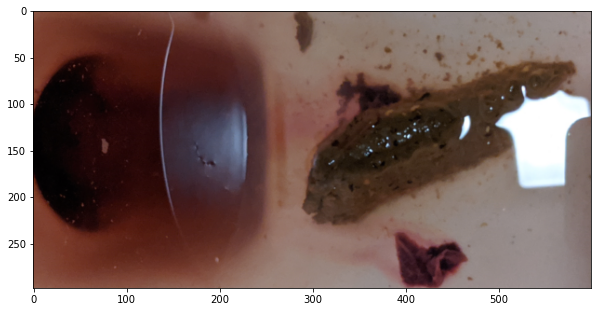

In [3]:
'''
Read and show the test image
'''
path_img = os.path.join('images', 'blood', 'crowdsourcing_00234.png')
img = imageio.imread(path_img)
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

In [4]:
def convert_to_lab(arr_rgb):
    '''
    This function will transform every rgb value in the list to lab. 
    '''
    
    list_lab = []
    for row in arr_rgb:
        r, g, b = row
        list_lab.append(convert_color(sRGBColor(r, g, b, is_upscaled=True), LabColor).get_value_tuple())
    return np.array(list_lab)


def convert_to_rgb(arr_lab):
    '''
    This function will transform every rgb value in the list to lab. 
    '''
    
    list_rgb = []
    for row in arr_lab:
        l, a, b = row
        list_rgb.append(convert_color(LabColor(l, a, b), sRGBColor).get_value_tuple())
    return np.array(list_rgb)

In [5]:
def find_the_cloeset_iscc(arr_img_lab, arr_iscc_lab):
    
    return arr_iscc_lab[np.argmin(cdist(arr_img_lab, arr_iscc_lab), 1)] 
      

In [6]:
arr_img_lab = convert_to_lab(img.reshape(img.shape[0]*img.shape[1], 3))
arr_iscc_lab = np.array(df_iscc['Lab'].tolist())
quantized_img_lab = find_the_cloeset_iscc(arr_img_lab, arr_iscc_lab)

In [7]:
quantized_img_rgb = convert_to_rgb(quantized_img_lab).reshape(img.shape[0], img.shape[1], 3)

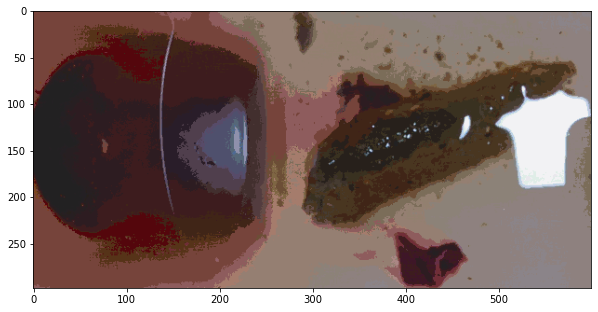

In [8]:
plt.figure(figsize = (10,10))
plt.imshow(quantized_img_rgb)
plt.show()

In [9]:
background_lab = np.array([95.7931405 , -0.15465805, -0.6054342])
(unique, counts) = np.unique(quantized_img_lab, return_counts=True, axis=0)
indices = np.argsort(counts)[::-1]
dict_color_count = {}
dict_color_name = {}


for i in indices:
    if cdist(unique[i].reshape(1, 3), background_lab.reshape(1, 3)) < 0.001:
        continue
    index_iscc = np.where(cdist(df_iscc['Lab'].tolist(), unique[i].reshape(1, 3))<0.01)
    hex_value = df_iscc.loc[index_iscc[0][0], 'hex']
    color_name = df_iscc.loc[index_iscc[0][0], 'color_name']
    dict_color_count[hex_value] = counts[i]
    dict_color_name[hex_value] = color_name


In [10]:
count_sum = sum(dict_color_count.values())

dict_color_count = {color: count for color, count in dict_color_count.items()}
# dict_color_count = {color: count for color, count in dict_color_count.items() if count/count_sum > 0.01}
dict_color_count

{'#79443B': 19954,
 '#8F817F': 19531,
 '#977F73': 16330,
 '#3E1D1E': 15838,
 '#8E8279': 10070,
 '#422518': 8740,
 '#2E1D21': 8688,
 '#4B3621': 7942,
 '#905D5D': 6656,
 '#7E6D5A': 5775,
 '#222222': 4458,
 '#28201C': 4417,
 '#56070C': 4235,
 '#6F4E37': 3595,
 '#958070': 3435,
 '#593319': 3379,
 '#8B8589': 3235,
 '#3B3121': 2793,
 '#50404D': 2689,
 '#A87C6D': 2445,
 '#282022': 2190,
 '#43302E': 2038,
 '#291E29': 1975,
 '#4C516D': 1528,
 '#543D3F': 1484,
 '#674C47': 1173,
 '#483C32': 985,
 '#242124': 887,
 '#722F37': 834,
 '#3F1728': 715,
 '#826644': 658,
 '#3E322C': 567,
 '#554C69': 490,
 '#BCD4E6': 436,
 '#536878': 432,
 '#8C92AC': 348,
 '#DFEDE8': 336,
 '#635147': 314,
 '#796878': 219,
 '#91A3B0': 213,
 '#E9E9ED': 134,
 '#654522': 113,
 '#673147': 106,
 '#81878B': 103,
 '#25241D': 101,
 '#AD8884': 98,
 '#C0C8E1': 96,
 '#848482': 87,
 '#5D555B': 84,
 '#436B95': 60,
 '#B4BCC0': 59,
 '#915F6D': 57,
 '#51585E': 55,
 '#36454F': 48,
 '#555555': 45,
 '#80461B': 43,
 '#A1CAF1': 37,
 '#9690AB': 

In [11]:
dominant_hex_values = list(dict_color_count.keys())
dominant_color_counts = list(dict_color_count.values())
dominant_color_names= [dict_color_name[hex_value] for hex_value in dominant_hex_values]

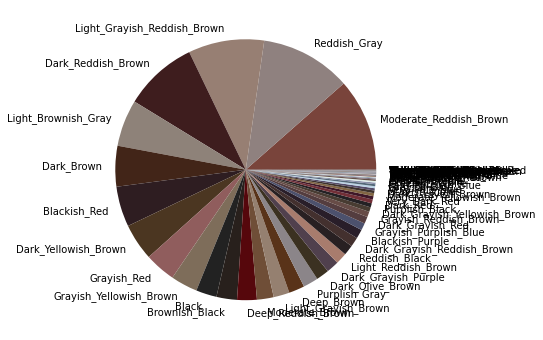

In [12]:
plt.figure(figsize = (8, 6))
plt.pie(dominant_color_counts, labels = dominant_color_names, colors = dominant_hex_values)
plt.show()